In [11]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# Multivariable Regression on monthly stock data using S&P500 Economic data

### Assemble prices data from yahoo finance

In [23]:
sym_descriptions = {"META":"META Returns",
                    "MSFT":"Microsoft Returns",
                    "XOM":"Exxon Mobil Returns",
                    "CL=F":"Crude Oil Returns",
                    "^GSPC":"S&P 500 Returns",
                    "CPIAUCNS":"CPI (Inflation)",
                    "DGS10":"Interest Rate"}

In [24]:
symbols = ['META', 'MSFT', 'XOM', '^GSPC', 'CL=F']

# Download data
start_date = '2012-05-18' # META is missing data before this date, no NAs after
end_date = '2024-12-31'
data = yf.download(symbols, start=start_date, end=end_date)

# Apply rolling average over 5 days centered at each day
data_smooth = data['Close'].rolling(window=5, min_periods=1).mean()

# Resample to monthly and aggregate by mean
data = data_smooth.resample('M').mean()

[*********************100%***********************]  5 of 5 completed
/var/folders/hm/rzyymww96rl2bp_b0kp72tth0000gn/T/ipykernel_14826/319725418.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data_smooth.resample('M').mean()


### Assemble macroeconomic data from FRED
1. Inflation Rate (CPIAUCNS) - Consumer Price Index, which is the primary indicator for inflation rates
1. Interest Rates (DGS10) - 10-Year Treasury Constant Maturity Rate 

In [25]:
fred = Fred(api_key="c260c55d3fb25aea0317107f0ad5d905")
economoic_ids = ['CPIAUCNS','DGS10']
for economoic_id in economoic_ids:
    data[economoic_id] = fred.get_series(economoic_id, start_date,end_date).resample("ME").mean()
    

In [26]:
# Using log-transformed changes
data = np.log(data / data.shift(1)).dropna()
# Standardize
data = (data - data.mean())/data.std()

In [27]:
data = data[["META","MSFT","XOM","CL=F","^GSPC","CPIAUCNS","DGS10"]]

In [28]:
# Part 2: Data Statistics
print("Dataset Summary Statistics:\n", data.describe())

Dataset Summary Statistics:
 Ticker          META          MSFT           XOM          CL=F         ^GSPC  \
count   1.510000e+02  1.510000e+02  1.510000e+02  1.510000e+02  1.510000e+02   
mean    6.470174e-17 -4.117383e-17  3.235087e-17  1.470494e-18  1.628572e-16   
std     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    -4.324349e+00 -3.818538e+00 -6.160235e+00 -5.832339e+00 -6.720127e+00   
25%    -3.944420e-01 -5.376136e-01 -5.862293e-01 -4.636724e-01 -4.568964e-01   
50%     6.108500e-02  2.882163e-02 -3.470280e-02  1.509100e-01  1.447336e-01   
75%     4.915252e-01  5.677297e-01  5.695241e-01  5.033016e-01  5.715443e-01   
max     3.741388e+00  2.571735e+00  2.471884e+00  3.995701e+00  1.853241e+00   

Ticker      CPIAUCNS         DGS10  
count   1.510000e+02  1.510000e+02  
mean   -2.352791e-17  2.793939e-17  
std     1.000000e+00  1.000000e+00  
min    -2.526549e+00 -5.793228e+00  
25%    -6.702156e-01 -5.703411e-01  
50%    -6.893475e-02 -2.0078

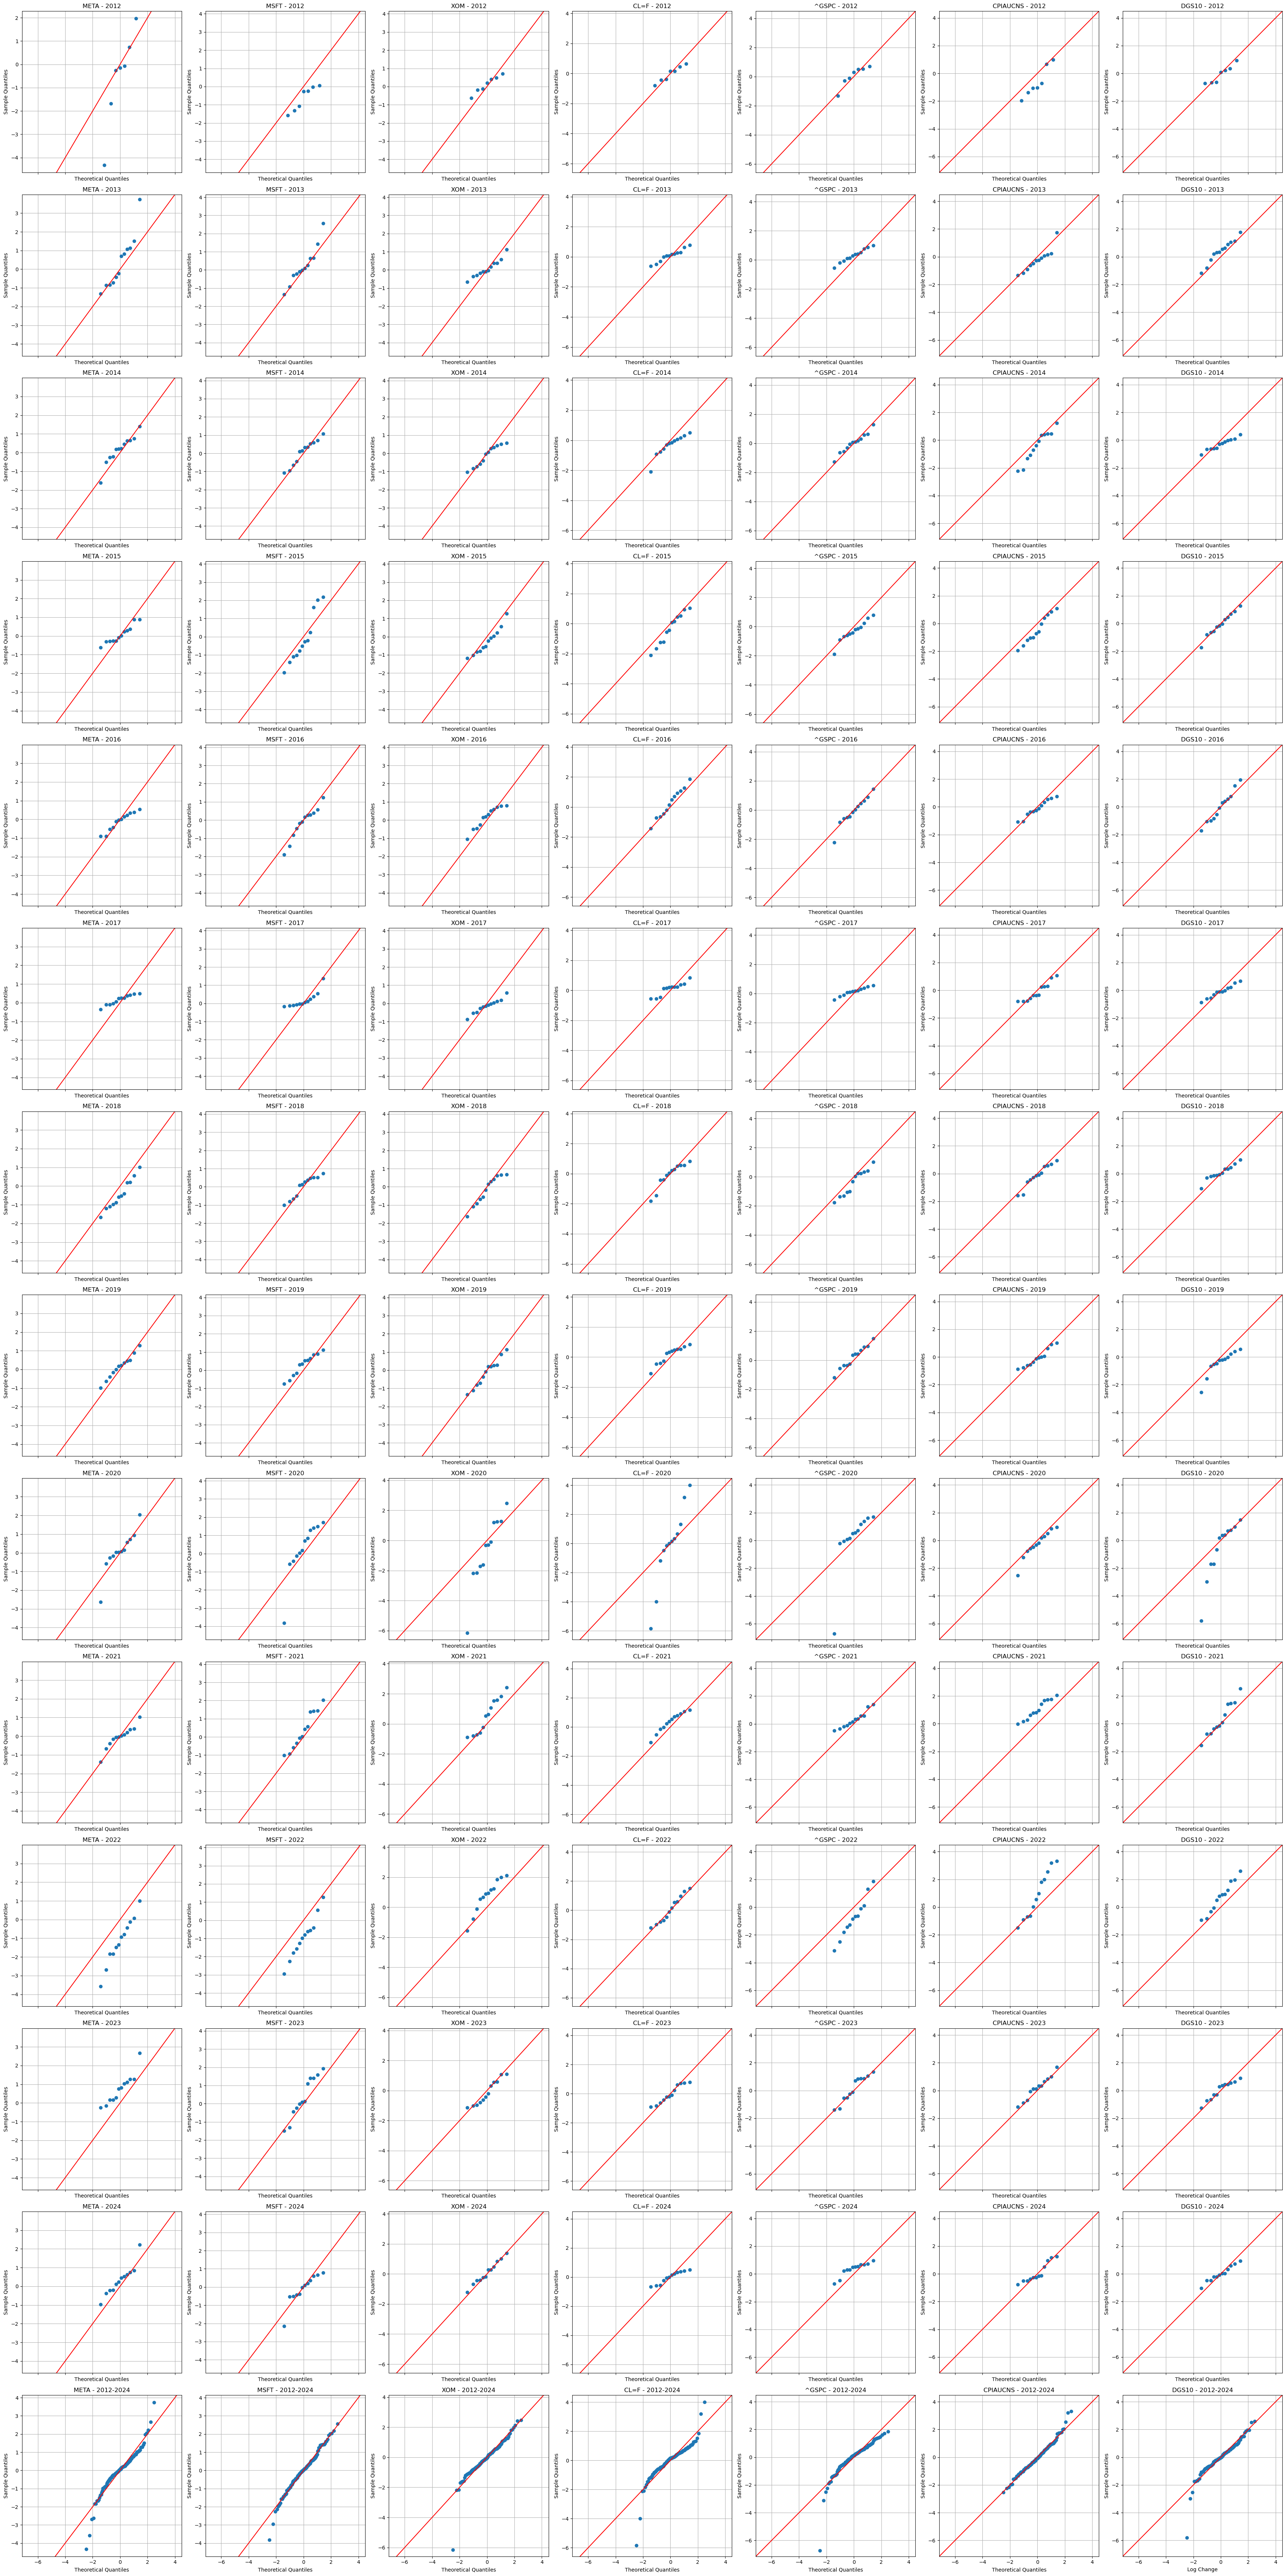

In [29]:
years = data.index.year.unique()
Ny = len(years)
symbols = data.columns

fig, axes = plt.subplots(Ny+1, len(symbols), figsize=(5*len(symbols), 5 * (Ny+1)), sharex=True)

for j, symbol in enumerate(symbols):
    for i, year in enumerate(years):
        ax = axes[i, j]
        yearly_data = data.loc[str(year), symbol].dropna()

        sm.qqplot(yearly_data, line='45', ax = ax)
        ax.set_title(f"{symbol} - {year}")
        ax.grid(True)

    # Plot for all years 2012-2021
    ax = axes[Ny, j]
    all_data = data.loc[:, symbol].dropna()

    sm.qqplot(all_data, line='45', ax = ax)
    ax.set_title(f"{symbol} - 2012-2024")
    ax.grid(True)


# Set labels
plt.xlabel("Log Change")
plt.tight_layout()
plt.show()

Q-Q plots of the log changes in closing price (averaged monthly) for each stock for each year as well as all years combined (in the last row).

Q-Q plots lie mostly on the diagonal, except for some years such as 2020 (the year of oandemic shutdown). Moreover, the plots deviate from the diagonal near the extreme ends.

Thus log-transformed changes are mostly normal, confirming that log transfomed changes is an appropriate preprocessing step.

The log-transformed changes are mostly normal, except for some years, and except near the tails. Thus there are outliers in the data. Interestingly we observe more negative change outliers than positive (in the last row, there are more deviations from the diagonal for negative quantiles than positive)

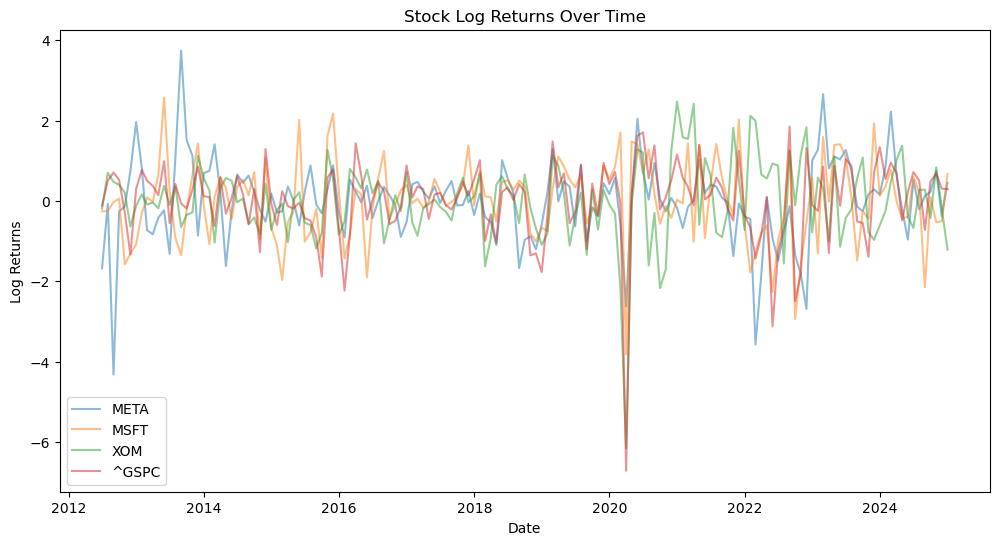

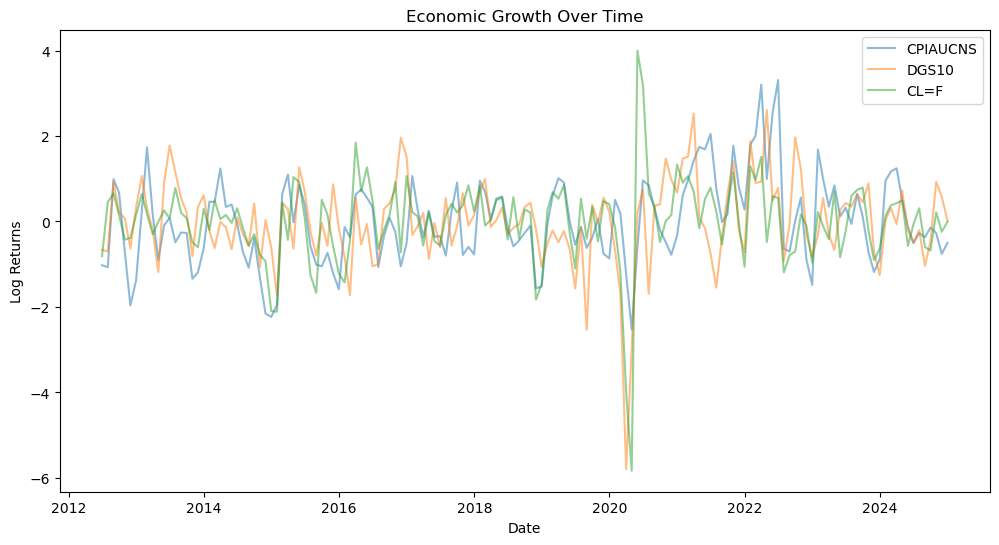

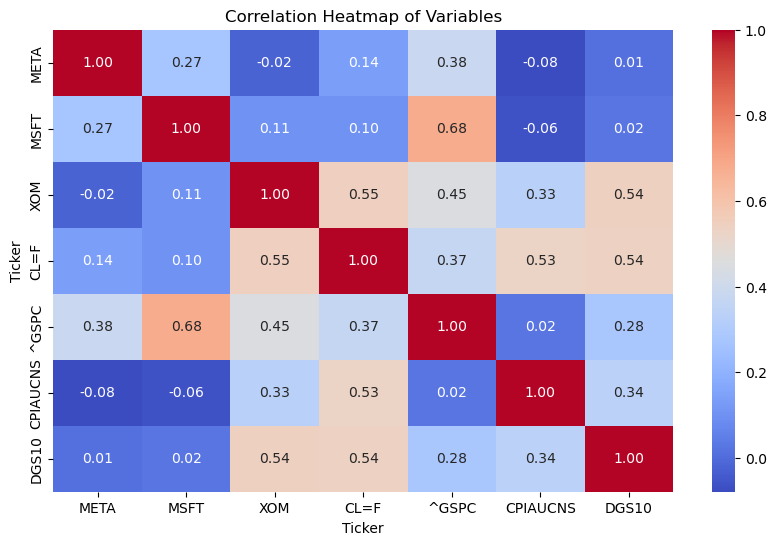

In [30]:
# Part 3: Data Visualization - Time series plot
plt.figure(figsize=(12,6))
for stock in ['META', 'MSFT', 'XOM', '^GSPC']:
    plt.plot(data.index, data[stock], label=stock, alpha = 0.5)
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.title("Stock Log Returns Over Time")
plt.show()

plt.figure(figsize=(12,6))
for sym in economoic_ids + ['CL=F']:
    plt.plot(data.index, data[sym], label=sym, alpha = 0.5)
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.title("Economic Growth Over Time")
plt.show()
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap of Variables")
plt.show()

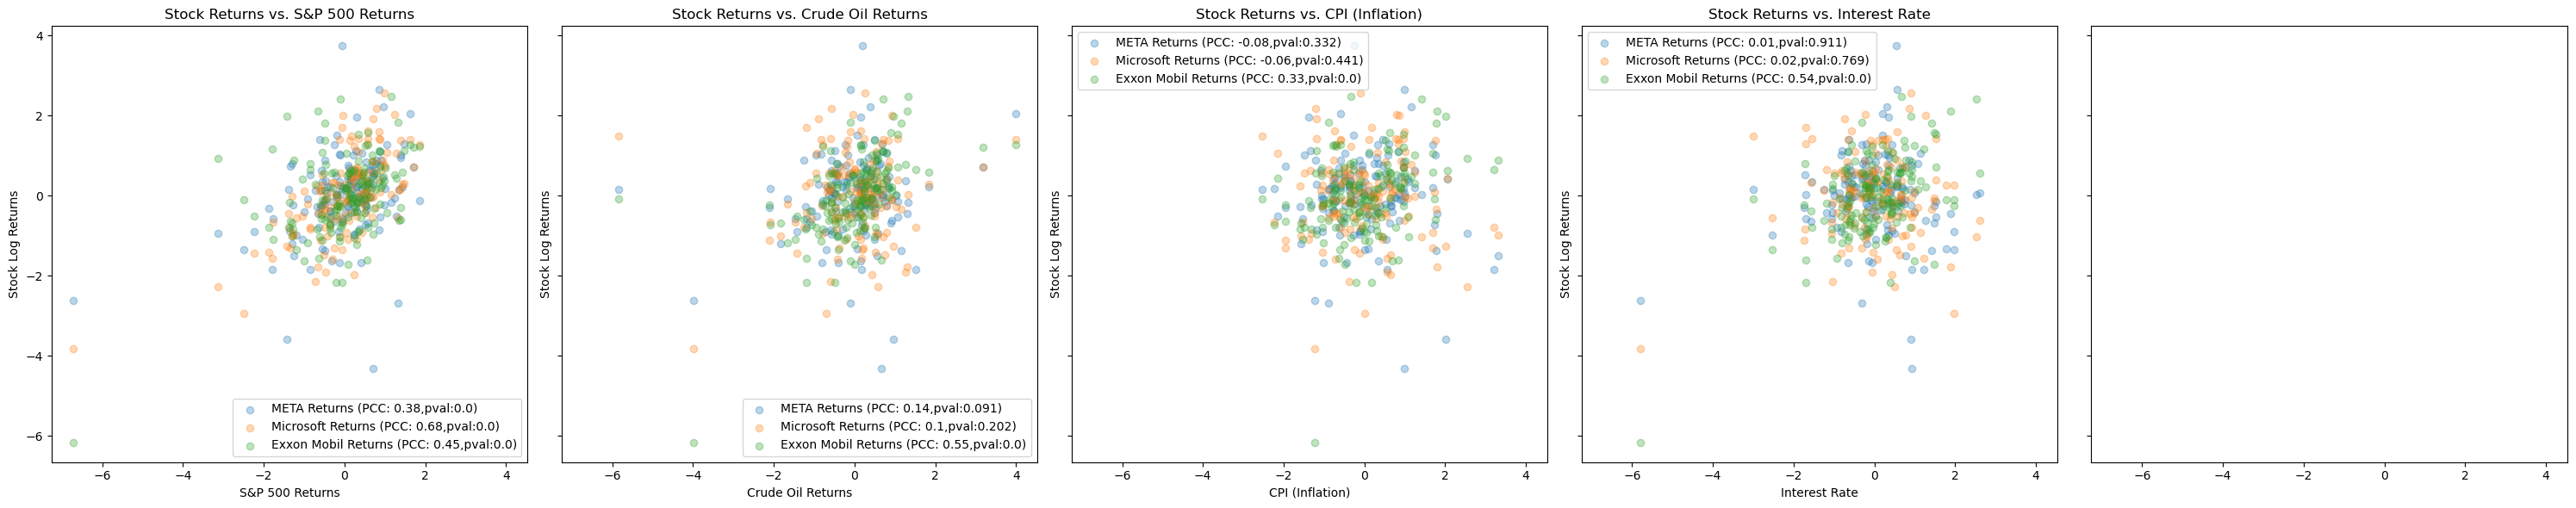

In [31]:
# Scatter Plot of Stock Returns vs. S&P 500

fig, axes = plt.subplots(1, 5, figsize=(6*5, 6), sharex=True, sharey=True)

for ax,econ_sym in zip(axes,['^GSPC','CL=F']+economoic_ids):
    for stock_sym in ['META','MSFT','XOM']:
        pcc,pcc_pval = ss.pearsonr(data[econ_sym], data[stock_sym])
        ax.scatter(data[econ_sym], data[stock_sym], alpha=0.3, label=sym_descriptions[stock_sym] + f" (PCC: {round(pcc,2)},pval:{round(pcc_pval,3)})")
    ax.set_xlabel(sym_descriptions[econ_sym])
    ax.set_ylabel("Stock Log Returns")
    ax.legend()
    ax.set_title(f"Stock Returns vs. {sym_descriptions[econ_sym]}")

plt.tight_layout()
plt.show()

# Multivariate Regression Analysis


In [32]:
X = data[['^GSPC','CL=F']+economoic_ids]
y_meta = data['META']
y_msft = data['MSFT']
y_xom = data['XOM']
X = sm.add_constant(X)

# Fit regression models
meta_model = sm.OLS(y_meta, X).fit()
msft_model = sm.OLS(y_msft, X).fit()
xom_model = sm.OLS(y_xom, X).fit()

In [34]:
# Print regression summaries
print("*"*80+"\nMeta Regression Summary:\n", meta_model.summary())
print("*"*80+"\nMicrosoft Regression Summary:\n", msft_model.summary())
print("*"*80+"\nExxonMobil Regression Summary:\n", xom_model.summary())

********************************************************************************
Meta Regression Summary:
                             OLS Regression Results                            
Dep. Variable:                   META   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     7.402
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           1.86e-05
Time:                        22:46:57   Log-Likelihood:                -199.82
No. Observations:                 151   AIC:                             409.6
Df Residuals:                     146   BIC:                             424.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------